In [2]:
import pywt
from numpy import genfromtxt
import matplotlib.pyplot as plt

In [3]:
sp500_data = genfromtxt('data/sp500_index_data.csv', delimiter=',', dtype=float, names=True)
print(sp500_data.dtype.names)

('Ntime', 'time', 'Close_Price', 'Open_Price', 'High_Price', 'Low_Price', 'Volume', 'MACD', 'CCI', 'ATR', 'BOLL', 'EMA20', 'MA10', 'MTM6', 'MA5', 'MTM12', 'ROC', 'SMI', 'WVAD', 'US_Dollar_Index', 'Federal_Fund_Rate')


In [4]:
haar_wavelet = pywt.Wavelet('haar')
haar_w_2 = haar_wavelet.wavefun(level=2)

In [9]:
max_level = 2
haar_dwt = pywt.wavedec(sp500_data['Close_Price'], wavelet=haar_wavelet, level=max_level)
for i in range(max_level):
    print(str("Size " + i + " th component: {}").format(haar_dwt[i].size))
plt.show()

TypeError: must be str, not int

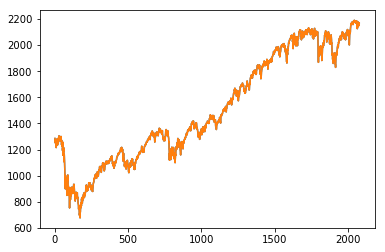

In [75]:
plt.plot(pywt.idwt(a,b,'haar'))
plt.plot(sp500_data['Close_Price'])
plt.show()

In [85]:
pywt.waverec(haar_dwt, haar_wavelet)
#sp500_data['Close_Price']

array([ 1284.91,  1261.52,  1262.9 , ...,  2151.13,  2168.27,  2168.27])